In [31]:
# download mnist dataset
import torch
from torchvision.datasets import MNIST
from torch import nn
from torch.nn import functional as F

mnist = MNIST(root='./data', download=True)

In [32]:
mnist.data.shape

torch.Size([60000, 28, 28])

In [33]:
class Model1(nn.Module):
    # this is supposed to be a linear model
    def __init__(self):
        super(Model1, self).__init__()
        self.input = nn.Flatten()
        self.linear = nn.Linear(28*28, 1) # one probability telling whether the image is '4'
        
    def forward(self, x):
        x = self.input(x)
        x = self.linear(x)
        x = F.sigmoid(x)
        return x


In [34]:
(mnist.test_labels == 4).float().mean()

/Users/lixinmei/miniconda3/envs/590d/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor(0.0974)

Training: 100%|██████████| 31250/31250 [00:03<00:00, 7834.69it/s]


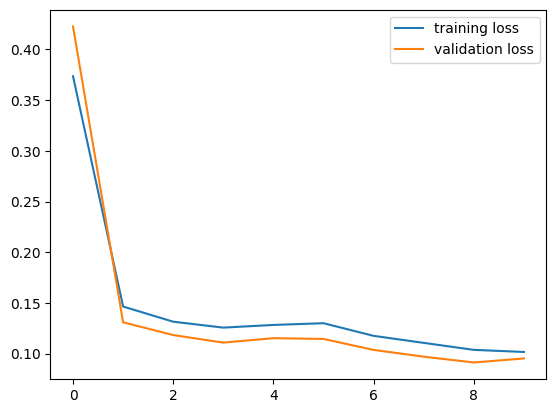

In [47]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

model1 = Model1()

def train_model(model, epochs=100):

    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
    # training loop
    # split training into train and validation
    train_X = mnist.data[:50000]
    train_y = mnist.targets[:50000]
    valid_X = mnist.data[50000:]
    valid_y = mnist.targets[50000:]



    # print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)
    # probability transformation of the target
    train_y = (train_y == 4).float().reshape(-1, 1)
    valid_y = (valid_y == 4).float().reshape(-1, 1)
    training_loss = []
    validation_loss = []

    dl = DataLoader(list(zip(train_X, train_y)), batch_size=16, shuffle=True)

    pbar = tqdm(total=epochs * len(dl), desc='Training')

    val_weight = torch.zeros(valid_y.shape)
    val_weight[valid_y == 1] = 0.9
    val_weight[valid_y == 0] = 0.1
    for epoch in tqdm(range(epochs)):
        loss_batch = torch.zeros(len(dl))
        optimizer.zero_grad()
        for i, batch in enumerate(dl):
            train_X, train_y = batch
            y_pred = model(train_X.float())
            weight = torch.zeros(y_pred.shape)
            weight[train_y == 1] = 0.9
            weight[train_y == 0] = 0.1
            loss = F.mse_loss(y_pred, train_y, weight=weight)
            # balance the dataset
            loss.backward()
            pbar.update(1)
            loss_batch[i] = loss.detach().item()
            
        validation_loss.append(F.mse_loss(model(valid_X.float()), valid_y, weight=val_weight).detach().item())
        training_loss.append(loss_batch.mean().detach().item())
        optimizer.step()

    pbar.close()

    return training_loss, validation_loss

training_loss, validation_loss = train_model(model1, epochs=10)


plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()


In [48]:
W = model1.linear.weight

In [49]:
# test mse
test_X = mnist.test_data
test_y = mnist.test_labels
test_y = (test_y == 4).float()

test_y_pred = model1(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = ((test_y_pred > 0.5) == test_y).float().mean()
print(test_loss, test_acc)

/var/folders/v9/h59kc0b515b1kkq2j6zz8pbm0000gn/T/ipykernel_19980/1170051993.py:7: UserWarning: Using a target size (torch.Size([60000])) that is different to the input size (torch.Size([60000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = F.mse_loss(test_y_pred, test_y)


tensor(0.2346, grad_fn=<MseLossBackward0>) tensor(0.7653)


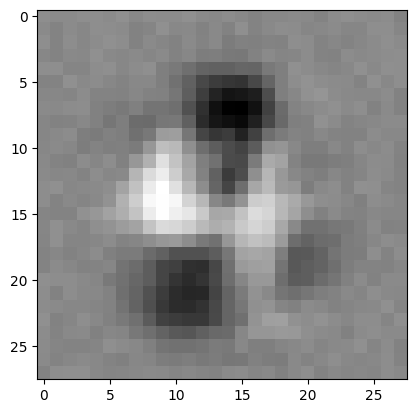

In [50]:
# %matplotlib QtAgg
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(W.detach().numpy().reshape(28, 28), cmap='gray')

# 2

In [51]:
class Model2(nn.Module):

    def __init__(self, d1, d2):
        super(Model2, self).__init__()
        self.input = nn.Flatten()
        self.A = nn.Linear(28*28, d1, bias=True)
        self.B = nn.Linear(d1, d2, bias=False)
        self.W = nn.Linear(d2, 1, bias=True)

    def forward(self, x):
        x = self.input(x)
        x = self.A(x)
        x = F.relu(x)
        z = self.B(x)
        # z = F.relu(z)
        y = self.W(z)
        y = F.sigmoid(y)
        return y
    


        

Training: 100%|██████████| 31250/31250 [00:10<00:00, 2924.07it/s]


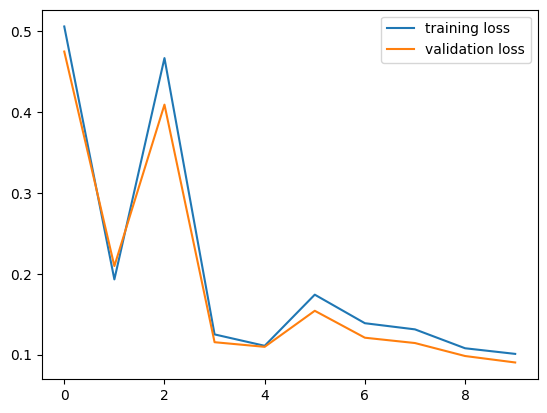

In [52]:

model2 = Model2(196, 10)
training_loss, validation_loss = train_model(model2, epochs=10)

plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()

In [53]:
# test mse
test_X = mnist.test_data
test_y = mnist.test_labels
test_y = (test_y == 4).float()

test_y_pred = model2(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = ((test_y_pred > 0.5) == test_y).float().mean()

print(test_loss, test_acc)

/var/folders/v9/h59kc0b515b1kkq2j6zz8pbm0000gn/T/ipykernel_19980/3113643176.py:7: UserWarning: Using a target size (torch.Size([60000])) that is different to the input size (torch.Size([60000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = F.mse_loss(test_y_pred, test_y)


tensor(0.2271, grad_fn=<MseLossBackward0>) tensor(0.7728)


# 3.

In [56]:



class Model3(nn.Module):

    def __init__(self, d1, d2):
        super(Model3, self).__init__()
        self.input = nn.Flatten()
        self.A = nn.Linear(28*28, d1, bias=True)
        self.B = nn.Linear(d1, d2, bias=False)
        self.W = nn.Linear(d2, 10, bias=True)

    def forward(self, x):
        x = self.input(x)
        x = self.A(x)
        x = F.relu(x)
        z = self.B(x)
        # z = F.relu(z)
        y = self.W(z)
        y = F.softmax(y, dim=1)
        return y

In [65]:
def train_model_logit(model, epochs=100):
    train_X = mnist.data[:50000]
    train_y = mnist.targets[:50000]
    valid_X = mnist.data[50000:]
    valid_y = mnist.targets[50000:]

    train_y = F.one_hot(train_y, num_classes=10).float()
    valid_y = F.one_hot(valid_y, num_classes=10).float()

    dl = DataLoader(list(zip(train_X, train_y)), batch_size=32, shuffle=True)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    training_loss = []
    validation_loss = []
    pbar = tqdm(total=epochs * len(dl), desc='Training')
    for epoch in tqdm(range(epochs)):
        loss_batch = torch.zeros(len(dl))
        optimizer.zero_grad()
        for i, batch in enumerate(dl):
            train_X, train_y = batch
            y_pred = model(train_X.float())
            loss = F.mse_loss(y_pred, train_y)
            loss.backward()
            pbar.update(1)
            loss_batch[i] = loss.detach().item()
        validation_loss.append(F.mse_loss(model(valid_X.float()), valid_y).detach().item())
        training_loss.append(loss_batch.mean().detach().item())
        optimizer.step()

    pbar.close()

    return training_loss, validation_loss






































































































Training: 100%|██████████| 156300/156300 [00:44<00:00, 3503.41it/s]


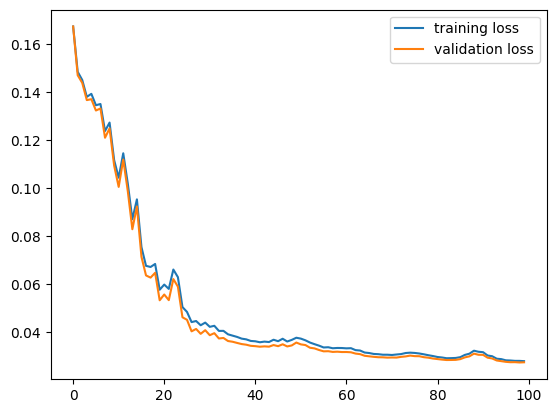

In [67]:
model3 = Model3(196, 20)
training_loss, validation_loss = train_model_logit(model3, epochs=100)

plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()


In [75]:
# test mse
test_X = mnist.test_data
test_y = mnist.test_labels
test_y = F.one_hot(test_y, num_classes=10).float()

test_y_pred = model3(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = (test_y_pred.argmax(dim=1) == test_y.argmax(dim=1)).float().mean()

print(test_loss, test_acc)

tensor(0.0278, grad_fn=<MseLossBackward0>) tensor(0.8381)


In [72]:
class Model4(nn.Module):

    def __init__(self, d1, d2):
        super(Model4, self).__init__()
        self.input = nn.Flatten()
        self.A = nn.Linear(28*28, d1, bias=True)
        self.B = nn.Linear(d1, d2, bias=False)
        self.W = nn.Linear(d2, 10, bias=True)

    def forward(self, x):
        x = self.input(x)
        x = self.A(x)
        x = F.layer_norm(x, x.shape)
        z = F.relu(x) + x
        z = self.B(z) 
        # layer norm
        z = F.layer_norm(z, z.shape)
        y = self.W(z)
        y = F.softmax(y, dim=1)
        return y

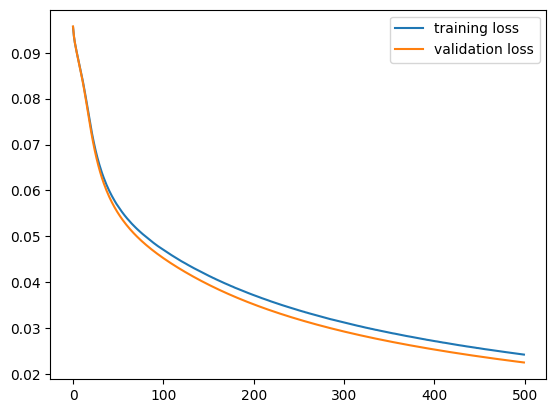

In [77]:
model4 = Model4(196, 20)
training_loss, validation_loss = train_model_logit(model4, epochs=500)

plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()

In [78]:
# test mse

test_X = mnist.test_data
test_y = mnist.test_labels
test_y = F.one_hot(test_y, num_classes=10).float()

test_y_pred = model4(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = (test_y_pred.argmax(dim=1) == test_y.argmax(dim=1)).float().mean()

print(test_loss, test_acc)

tensor(0.0239, grad_fn=<MseLossBackward0>) tensor(0.8938)


/Users/lixinmei/miniconda3/envs/590d/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/lixinmei/miniconda3/envs/590d/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
